In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import zipfile
import seaborn
import os
import matplotlib.pylab as pl
%pylab inline
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Time series clustering

### Data:
Downloading the census bureau business data for all years 1994-2014

In [2]:
#the cell needs to be run only once
 """
    # Years 1994-99       
!for ((y=94; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

    # Years 2000-01
!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

    # Years 2002-09
!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

    # Years 2010-14
!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done
 """

IndentationError: unexpected indent (<ipython-input-2-23bf6a88a7be>, line 2)

In [3]:
#the cell needs to be run only once
"""
for i in range(94, 100):
    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp' + str(i) + 'totals.zip' + \
              ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp' + str(i) + 'totals.zip')
for i in range(2):
    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp0' + str(i) + 'totals.zip' + \
              ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0' + str(i) + 'totals.zip')
for i in range(2, 10):
    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp0' + str(i) + 'totals.zip' + \
              ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0' + str(i) + 'totals.zip')
for i in range(10, 16):
    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp' + str(i) + 'totals.zip' + \
              ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp' + str(i) + 'totals.zip')
"""

"\nfor i in range(94, 100):\n    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp' + str(i) + 'totals.zip' +               ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp' + str(i) + 'totals.zip')\nfor i in range(2):\n    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp0' + str(i) + 'totals.zip' +               ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0' + str(i) + 'totals.zip')\nfor i in range(2, 10):\n    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp0' + str(i) + 'totals.zip' +               ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0' + str(i) + 'totals.zip')\nfor i in range(10, 16):\n    os.system('curl -o ' + os.getenv('PUIDATA') + '/zbp' + str(i) + 'totals.zip' +               ' https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp' + str(i) + 'totals.zip')\n"

Downloading the NYC ZIP geometry and read it in with geopandas

https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

Downloading it as a shape file. Then unzipping the data into PUIdata/NYC_ZIP directory, reading in the shape file with the function:

        geopandas.GeoDataFrame.from_file(filename)

In [3]:
PUIdata = os.getenv('PUIDATA')

if not os.path.isdir(PUIdata + '/NYC_ZIP'):
    urllib.urlretrieve(' https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip', "NYC_ZIP.zip")
    os.system('mv NYC_ZIP.zip ' + PUIdata)
    print('moved')
    os.system('unzip ' + PUIdata + '/NYC_ZIP.zip -d ' + PUIdata + '/NYC_ZIP')
    print('unzipped')

if os.path.isdir(PUIdata + '/NYC_ZIP'):
    for file in os.listdir(PUIdata + '/NYC_ZIP'):
        if file.endswith('.shp'):
            zipshp = file
            print(zipshp)

ZIP_CODE_040114.shp


In [4]:
zipshp = gpd.GeoDataFrame.from_file(PUIdata + '/NYC_ZIP/' + zipshp)
zipshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [5]:
zipshp.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

In [6]:
zipshp.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry'],
      dtype='object')

In [7]:
zipshp = zipshp[['ZIPCODE', 'geometry', 'PO_NAME']]
zipshp = zipshp.rename(columns={'ZIPCODE' : 'zip'})
zipshp['zip'] = pd.to_numeric(zipshp['zip'])
zipshp.head()

,zip,geometry,PO_NAME
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",Jamaica
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Brooklyn
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",Brooklyn
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",Brooklyn
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",Brooklyn


### Using zipfile module in python to unzip the files

In [8]:
years = []
for i in range(94, 100, 1):
    years.append(str(i))
for i in range(0, 10, 1):
    years.append('0'+str(i))
for i in range(10, 15, 1):
    years.append(str(i))

In [9]:
for i in years:
    zf = zipfile.ZipFile('zbp'+ i +'totals.zip')
    business_data = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))

In [10]:
print(business_data.head())

    zip            name empflag emp_nf    emp qp1_nf    qp1 ap_nf      ap  \
0   501  HOLTSVILLE, NY       B      D      0      D      0     D       0   
1  1001      AGAWAM, MA     NaN      G   9110      G  88574     G  364418   
2  1002     AMHERST, MA     NaN      H  17513      G  99432     G  421772   
3  1003     AMHERST, MA     NaN      G    227      H   1911     H    8026   
4  1004     AMHERST, MA       C      S      0      S      0     H    4921   

   est        city stabbr   cty_name  
0    4  HOLTSVILLE     NY    SUFFOLK  
1  458      AGAWAM     MA    HAMPDEN  
2  560     AMHERST     MA  HAMPSHIRE  
3   18     AMHERST     MA  HAMPSHIRE  
4   13     AMHERST     MA  HAMPSHIRE  


In [11]:
#merging dataframes
for i in years:
    zf = zipfile.ZipFile('zbp'+i+'totals.zip')
    df = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    df = df[['zip', 'est']]
    df.rename(columns={'est' : 'est_'+str(i)}, inplace=True)
    zipshp = zipshp.merge(df, on = 'zip', how = 'inner')

In [12]:
zipshp.columns

Index(['zip', 'geometry', 'PO_NAME', 'est_94', 'est_95', 'est_96', 'est_97',
       'est_98', 'est_99', 'est_00', 'est_01', 'est_02', 'est_03', 'est_04',
       'est_05', 'est_06', 'est_07', 'est_08', 'est_09', 'est_10', 'est_11',
       'est_12', 'est_13', 'est_14'],
      dtype='object')

In [13]:
zipshp.head()

,zip,geometry,PO_NAME,est_94,est_95,est_96,est_97,est_98,est_99,est_00,...,est_05,est_06,est_07,est_08,est_09,est_10,est_11,est_12,est_13,est_14
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",Jamaica,51,50,53,51,51,58,65,...,82,80,84,90,92,98,101,95,99,109
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Brooklyn,406,420,433,456,476,473,477,...,556,565,556,592,621,675,674,726,755,772
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",Brooklyn,505,494,502,527,519,541,520,...,587,570,587,602,647,699,713,721,731,752
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",Brooklyn,381,387,388,410,416,409,417,...,491,499,514,520,543,580,597,623,673,696
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",Brooklyn,985,1015,1049,1075,1118,1149,1161,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


### Data cleaning

#### Instructions:

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [14]:
#whitening the time series
est_mean = zipshp.iloc[:, range(4,24)].mean(axis = 1)
est_std = zipshp.iloc[:, range(4,24)].std(axis = 1)
zipshp.iloc[:, range(4,24)] = zipshp.iloc[:, range(3,24)].apply(lambda x: (x - est_mean) / est_std)
zipshp.head()

,zip,geometry,PO_NAME,est_94,est_95,est_96,est_97,est_98,est_99,est_00,...,est_05,est_06,est_07,est_08,est_09,est_10,est_11,est_12,est_13,est_14
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",Jamaica,51,-1.441415,-1.284455,-1.389095,-1.389095,-1.022855,-0.656615,...,0.232824,0.128184,0.337464,0.651383,0.756023,1.069943,1.226903,0.912983,1.122263,1.645463
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Brooklyn,406,-1.421160,-1.298198,-1.080649,-0.891476,-0.919852,-0.882018,...,-0.134786,-0.049658,-0.134786,0.205725,0.480026,0.990792,0.981333,1.473182,1.747483,1.908279
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",Brooklyn,505,-1.271502,-1.174764,-0.872457,-0.969195,-0.703165,-0.957103,...,-0.146921,-0.352490,-0.146921,0.034463,0.578615,1.207413,1.376705,1.473443,1.594366,1.848303
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",Brooklyn,381,-1.239637,-1.228876,-0.992140,-0.927576,-1.002901,-0.916815,...,-0.120520,-0.034434,0.126977,0.191541,0.439038,0.837185,1.020118,1.299897,1.837934,2.085431
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",Brooklyn,985,-1.460972,-1.299065,-1.175254,-0.970489,-0.822868,-0.765725,...,0.048572,0.043810,0.262861,0.358100,0.643818,0.724772,0.958108,1.348590,1.739071,1.972408


In [15]:
#checking std and mean values
est_std_new = zipshp.iloc[:, range(4,24)].std(axis = 1)
print (est_std_new)
est_mean_new = zipshp.iloc[:, range(4,24)].mean(axis = 1)
print (est_mean_new)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
213    1.0
214    1.0
215    1.0
216    1.0
217    1.0
218    1.0
219    1.0
220    1.0
221    1.0
222    1.0
223    1.0
224    1.0
225    1.0
226    1.0
227    1.0
228    1.0
229    1.0
230    1.0
231    1.0
232    1.0
233    1.0
234    1.0
235    1.0
236    1.0
237    1.0
238    1.0
239    1.0
240    1.0
241    1.0
242    1.0
dtype: float64
0      1.554312e-16
1      1.110223e-17
2      2.664535e-16
3      1.554312e-16
4      2.331468e-16
5      7.216450e-16
6     -3.108624e-16
7     -5.662137e-16
8      4.440892e-16
9      3.663736e-16
10     5.107026e-16
11    -1.276756e-15
12     1.820766e-15
13    -8.104628e-16
14    -5.329071e-16
15    -5.32907

In [16]:
dataset = zipshp.iloc[:, range(4,24)]
km = KMeans(n_clusters = 5, random_state = None)
km_res = km.fit(dataset)
centers = km.cluster_centers_
zipshp['km'] = km.labels_
zipshp['km'] = zipshp['km'].replace([0, 1, 2, 3, 4],[1, 2, 3, 4, 5])
zipshp.head()

,zip,geometry,PO_NAME,est_94,est_95,est_96,est_97,est_98,est_99,est_00,...,est_06,est_07,est_08,est_09,est_10,est_11,est_12,est_13,est_14,km
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",Jamaica,51,-1.441415,-1.284455,-1.389095,-1.389095,-1.022855,-0.656615,...,0.128184,0.337464,0.651383,0.756023,1.069943,1.226903,0.912983,1.122263,1.645463,1
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Brooklyn,406,-1.421160,-1.298198,-1.080649,-0.891476,-0.919852,-0.882018,...,-0.049658,-0.134786,0.205725,0.480026,0.990792,0.981333,1.473182,1.747483,1.908279,1
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",Brooklyn,505,-1.271502,-1.174764,-0.872457,-0.969195,-0.703165,-0.957103,...,-0.352490,-0.146921,0.034463,0.578615,1.207413,1.376705,1.473443,1.594366,1.848303,1
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",Brooklyn,381,-1.239637,-1.228876,-0.992140,-0.927576,-1.002901,-0.916815,...,-0.034434,0.126977,0.191541,0.439038,0.837185,1.020118,1.299897,1.837934,2.085431,1
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",Brooklyn,985,-1.460972,-1.299065,-1.175254,-0.970489,-0.822868,-0.765725,...,0.043810,0.262861,0.358100,0.643818,0.724772,0.958108,1.348590,1.739071,1.972408,1


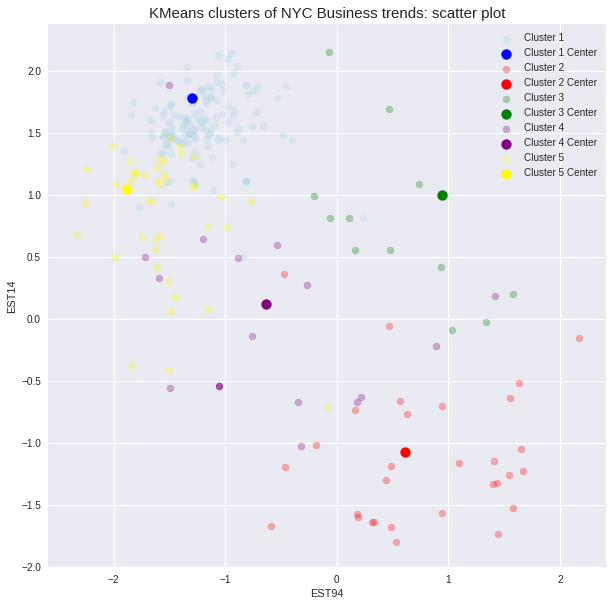

In [18]:
plt.figure(figsize=(10,10))

plt.scatter(zipshp[km.labels_ == 0].iloc[:,5], zipshp[km.labels_ == 0].iloc[:,22], \
           color='lightblue', alpha=0.3, label="Cluster 1")
plt.scatter(centers[0][0], centers[0][-1], marker='o', s=100, color='blue', label="Cluster 1 Center")

plt.scatter(zipshp[km.labels_ == 1].iloc[:,5], zipshp[km.labels_ == 1].iloc[:,22], \
           color='red', alpha=0.3, label="Cluster 2")
plt.scatter(centers[1][0], centers[1][-1], marker='o', s=100, color='red', label="Cluster 2 Center")

plt.scatter(zipshp[km.labels_ == 2].iloc[:,5], zipshp[km.labels_ == 2].iloc[:,22], \
           color='green', alpha=0.3, label="Cluster 3")
plt.scatter(centers[2][0], centers[2][-1], marker='o', s=100, color='green', label="Cluster 3 Center")

plt.scatter(zipshp[km.labels_ == 3].iloc[:,5], zipshp[km.labels_ == 3].iloc[:,22], \
           color='purple', alpha=0.3, label="Cluster 4")
plt.scatter(centers[3][0], centers[3][-1], marker='o', s=100, color='purple', label="Cluster 4 Center")

plt.scatter(zipshp[km.labels_ == 4].iloc[:,5], zipshp[km.labels_ == 4].iloc[:,22], \
           color='yellow', alpha=0.3, label="Cluster 5")
plt.scatter(centers[4][0], centers[4][-1], marker='o', s=100, color='yellow', label="Cluster 5 Center")


plt.xlabel("EST94")
plt.ylabel("EST14")
plt.title("KMeans clusters of NYC Business trends: scatter plot", fontsize=15)
plt.legend(fontsize=10, loc='best')

### Fig. 1.  Scatter plot of 5 k-means clusters of NYC business trends at the zipcode level.

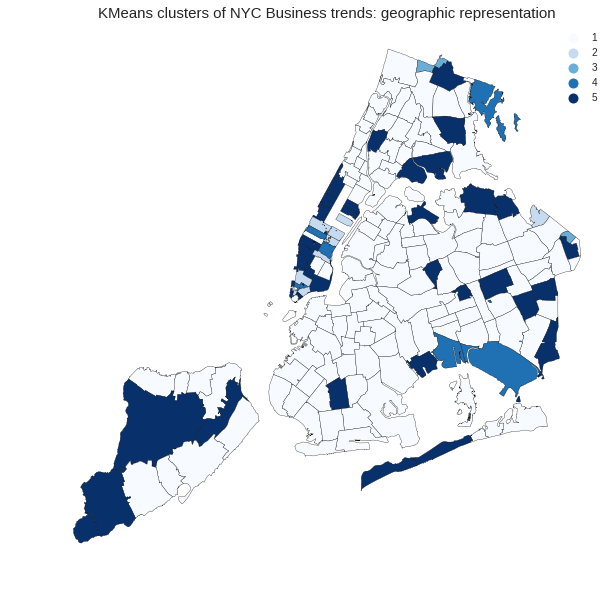

In [19]:
#Plotting KMeans cluster
f, ax = plt.subplots(figsize=(10,10))
zipshp.plot(cmap='Blues', column='km', edgecolor='k', ax=ax, categorical=True, legend=True)
ax.set_title("KMeans clusters of NYC Business trends: geographic representation", fontsize=15)
ax.axis('off');

### Fig. 2. Geographic representation of 5 k-means clusters of NYC business trends at the zipcode level.

### And if you use hierarchical clustering and make a dandrogram it may look like this:

In [20]:
dataset = zipshp.iloc[:, range(4,24)]
ag = AgglomerativeClustering(n_clusters = 5,  compute_full_tree=True)
ag_res = ag.fit(dataset)
zipshp['ag'] = ag_res.labels_
zipshp['ag'] = zipshp['ag'].replace([0, 1, 2, 3, 4],[1, 2, 3, 4, 5])
zipshp.head()

,zip,geometry,PO_NAME,est_94,est_95,est_96,est_97,est_98,est_99,est_00,...,est_07,est_08,est_09,est_10,est_11,est_12,est_13,est_14,km,ag
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",Jamaica,51,-1.441415,-1.284455,-1.389095,-1.389095,-1.022855,-0.656615,...,0.337464,0.651383,0.756023,1.069943,1.226903,0.912983,1.122263,1.645463,1,5
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Brooklyn,406,-1.421160,-1.298198,-1.080649,-0.891476,-0.919852,-0.882018,...,-0.134786,0.205725,0.480026,0.990792,0.981333,1.473182,1.747483,1.908279,1,5
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",Brooklyn,505,-1.271502,-1.174764,-0.872457,-0.969195,-0.703165,-0.957103,...,-0.146921,0.034463,0.578615,1.207413,1.376705,1.473443,1.594366,1.848303,1,5
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",Brooklyn,381,-1.239637,-1.228876,-0.992140,-0.927576,-1.002901,-0.916815,...,0.126977,0.191541,0.439038,0.837185,1.020118,1.299897,1.837934,2.085431,1,5
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",Brooklyn,985,-1.460972,-1.299065,-1.175254,-0.970489,-0.822868,-0.765725,...,0.262861,0.358100,0.643818,0.724772,0.958108,1.348590,1.739071,1.972408,1,5


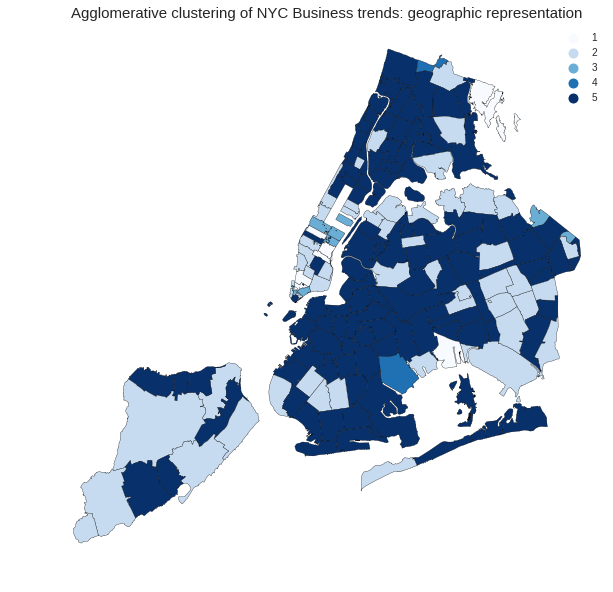

In [21]:
#Plotting Agglomerative cluster
f, ax = plt.subplots(figsize=(10,10))
zipshp.plot(cmap='Blues', column='ag', edgecolor='k', ax=ax, categorical=True, legend=True)
ax.set_title("Agglomerative clustering of NYC Business trends: geographic representation", fontsize=15)
ax.axis('off');

### Fig. 3. Geographic representation of 5 clusters by Agglomerative clustering of NYC business trends at the zipcode level.

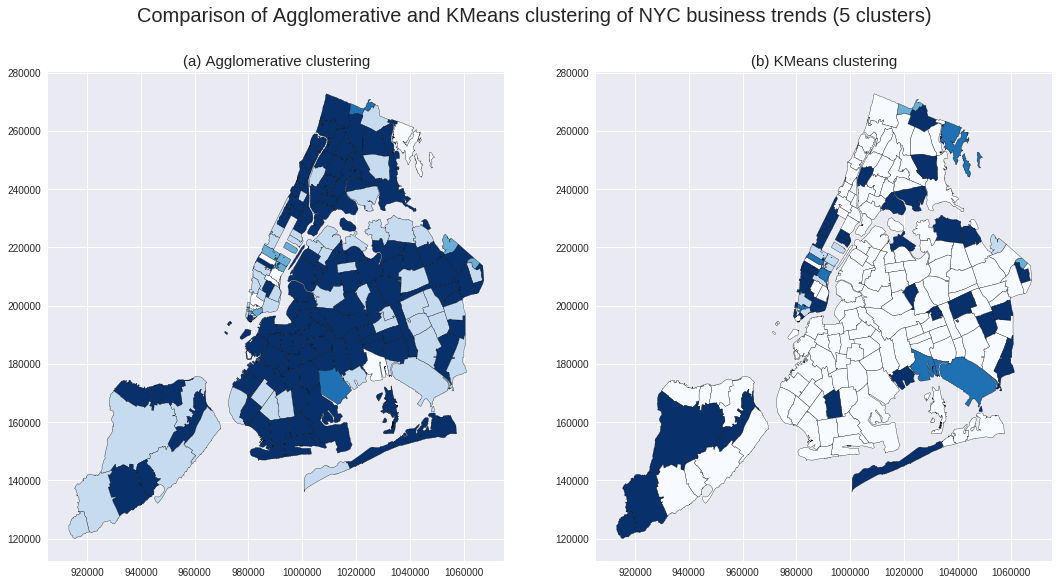

In [22]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(18,9)

zipshp.plot(column='ag', cmap='Blues', edgecolor='k', ax=axs[0])
axs[0].set_title('(a) Agglomerative clustering', fontsize=15)

zipshp.plot(column='km', cmap='Blues', edgecolor='k', ax=axs[1])
axs[1].set_title('(b) KMeans clustering', fontsize=15)

plt.suptitle('Comparison of Agglomerative and KMeans clustering of NYC business trends (5 clusters)', fontsize=20);

### Fig. 4. Geographic representation of 5 clusters by (a) Agglomerative and (b) KMeans clustering of NYC business trends at the zipcode level.¶

From the above plot we see a side-by-side comparison of two clustering techniques. We can derive that clusters are mostly similar, with the exception of several boroughts. 

## ASH Score 100